# Amazon SageMaker로 A/B 테스트

A/B 테스팅은 카나리아 테스팅과 비슷하지만 더 큰 사용자 그룹과 더 긴 기간(일반적으로 며칠 또는 몇 주)이 있습니다. 이러한 유형의 테스트에서 Amazon SageMaker 엔드포인트 구성은 두 가지 프로덕션 변형을 사용합니다. 하나는 모델 A용이고 다른 하나는 모델 B입니다. 시작하려면 두 모델 간의 트래픽 균형을 동등하게(50/50)하도록 두 모델의 설정을 구성하고 다음을 확인하십시오. 두 모델 모두 동일한 인스턴스 구성을 갖습니다. 동일한 가중치의 초기 설정으로 두 모델의 성능을 모니터링한 후에는 트래픽 가중치를 점진적으로 변경하여 모델의 균형이 맞지 않게 하거나(60/40, 80/20 등) 트래픽 가중치를 변경할 수 있습니다. 단일 모델이 모든 실시간 트래픽을 처리할 때까지 계속해서 단일 단계로 가중치를 부여합니다.

수행 중인 A/B 테스트의 경우 모델은 동일한 분류 문제에 대해 두 가지 다른 알고리즘을 사용하고 있습니다. **decision tree** 알고리즘으로 ModelA 코드를 업데이트하고 **random Forest** 알고리즘으로 ModelB 코드를 업데이트했습니다. 최적화된 반복을 찾기 위해 동일한 알고리즘으로 다른 하이퍼파라미터를 사용하는 것도 모범 사례입니다.

이 노트북에서는 다음을 수행할 수 있습니다.
* 특정 변형을 호출하여 모델 평가
* 트래픽 분포를 지정하여 점진적으로 새로운 모델 출시

**참고** 코드 셀의 상태는 코드 셀 왼쪽에 표시됩니다.
  - 셀이 실행되지 않음: In [ ]
  - 셀이 실행되도록 예약되었거나 현재 실행 중: [\*]
  - 셀 실행 완료: [#]에서 #은 고유한 실행 번호입니다.

### 전제 조건

먼저 최신 SageMaker 기능이 포함된 boto3의 업데이트된 버전이 있는지 확인하십시오.

In [1]:
!pip install -U awscli

  Obtaining dependency information for awscli from https://files.pythonhosted.org/packages/7c/af/73e833c99b7e3910b61c5d52ec215369ee94954516bd983504a494339111/awscli-1.29.62-py3-none-any.whl.metadata
  Obtaining dependency information for botocore==1.31.62 from https://files.pythonhosted.org/packages/a8/3f/74138007b045447eac6141c8144efe8e1c9f377cf56c85edfe1111a22f97/botocore-1.31.62-py3-none-any.whl.metadata
  Obtaining dependency information for s3transfer<0.8.0,>=0.7.0 from https://files.pythonhosted.org/packages/5a/4b/fec9ce18f8874a96c5061422625ba86c3ee1e6587ccd92ff9f5bf7bd91b2/s3transfer-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 22.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 29.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.41
    Uninstalling botocore-1.31.4

## 1단계: 구성

필수 import 및 변수 초기화를 수행합니다.

In [2]:
%%time
%matplotlib inline
from datetime import datetime, timedelta
import time
import os
import boto3
import re
import json
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

region= boto3.Session().region_name
role = get_execution_role()
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

CPU times: user 2.68 s, sys: 442 ms, total: 3.12 s
Wall time: 29.1 s


S3 modelDataBucket의 이름을 결정합니다.

In [3]:
bucket = ''
s3 = boto3.resource('s3')
for buckets in s3.buckets.all():
    if 'modeldatabucket' in buckets.name:
        bucket = buckets.name
print(bucket)
prefix = 'v1.0/validation'

labstack-2ff18e01-e448-468f-bff5-modeldatabucket-ebc3zim3vnjd


앞에서 메모장에 복사해둔 **엔드포인트 이름**을 입력합니다.

In [18]:
endpoint_name = 'Endpoint-dedea004-0940-4af8-b8d2-406b1e7bf105'
if 'enter_endpoint_name' in endpoint_name:
    raise Exception('You need to update the endpoint_name')

S3 버킷에서 데이터를 다운로드합니다.

In [19]:
S3Downloader.download(s3_uri=f"s3://{bucket}/{prefix}/iris.csv", local_path= 'data/')

['data/iris.csv']

pandas 데이터 프레임으로 데이터를 읽어들입니다.

In [20]:
import pandas as pd
import numpy as np

shape=pd.read_csv("data/iris.csv", header=None)
shape.sample(3)

,0,1,2,3,4
20,2,6.5,3.0,5.2,2.0
47,2,4.9,2.5,4.5,1.7
9,1,5.5,2.3,4.0,1.3


트래픽 생성을 위한 샘플 데이터를 생성합니다.

In [21]:
import itertools

a = [10*i for i in range(3)]
b = [10+i for i in range(10)]
indices = [i+j for i,j in itertools.product(a,b)]

test_data = shape.drop(shape.columns[[0]],axis=1)
test_data = test_data.iloc[indices]
test_data_with_label = shape.iloc[indices]

무작위 테스트 데이터를 로컬 디렉토리로 업데이트합니다.

In [22]:
test_data.to_csv("data/data-test.csv",index=False,header=False)
test_data_with_label.to_csv("data/data-test-label.csv",index=False,header=False)

## 2단계: 배포된 모델 호출

데이터를 엔드포인트로 보내 실시간으로 추론할 수 있습니다.

이 단계는 약 2분 동안 샘플 데이터가 포함된 엔드포인트를 호출합니다.

In [23]:
# get a subset of test data for a quick test
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
predictions = ''

with open('data/data-test.csv', 'r') as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip('\n')
        response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType="text/csv",
                                   Body=payload)
        predictions = ','.join([predictions, response['Body'].read().decode('utf-8')])
        time.sleep(0.5)

predictions = predictions.replace('\n','')
predictions = predictions.split(",")
predictions.pop(0)
print("="*20)
print(predictions)
print("Done!") 

Sending test traffic to the endpoint Endpoint-dedea004-0940-4af8-b8d2-406b1e7bf105. 
Please wait...
..............................====================
['0', '0', '0', '0', '0', '2', '1', '1', '2', '1', '2', '1', '0', '2', '0', '2', '2', '0', '0', '2', '2', '2', '0', '1', '0', '0', '2', '1', '2', '1']
Done!


In [24]:
labels = test_data_with_label[0].to_numpy()
preds = np.array(predictions)
preds = preds.astype(np.int)

/tmp/ipykernel_14215/2670679079.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  preds = preds.astype(np.int)


In [25]:
# Calculate accuracy
accuracy = np.count_nonzero(preds == labels) / len(labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9333333333333333


### 변형별 호출

Amazon SageMaker는 각 변형에 대해 지연 시간 및 호출(지표의 전체 목록 [여기](https://alpha-docs-aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html))과 같은 지표를 내보냅니다. Amazon CloudWatch에서. CloudWatch를 쿼리하여 변형별 호출 수를 가져오겠습니다. 그러면 변형 간에 호출이 분할되는 방식이 표시됩니다.

In [26]:
cw = boto3.Session().client("cloudwatch")

def get_invocation_metrics_for_endpoint_variant(endpoint_name,
                                                variant_name,
                                                start_time,
                                                end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {
                "Name": "EndpointName",
                "Value": endpoint_name
            },
            {
                "Name": "VariantName",
                "Value": variant_name
            }
        ]
    )
    return pd.DataFrame(metrics["Datapoints"])\
            .sort_values("Timestamp")\
            .set_index("Timestamp")\
            .drop("Unit", axis=1)\
            .rename(columns={"Sum": variant_name})

def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(endpoint_name, "Variant1", start_time, end_time)
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(endpoint_name, "Variant2", start_time, end_time)
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

Waiting a minute for initial metric creation...


,Variant1,Variant2
Timestamp,,
2023-10-11 06:09:00+00:00,20.0,20.0
2023-10-11 06:10:00+00:00,0.0,0.0
2023-10-11 06:11:00+00:00,0.0,0.0
2023-10-11 06:12:00+00:00,0.0,0.0
2023-10-11 06:13:00+00:00,0.0,0.0
2023-10-11 06:14:00+00:00,0.0,0.0
2023-10-11 06:15:00+00:00,0.0,0.0
2023-10-11 06:16:00+00:00,0.0,0.0
2023-10-11 06:17:00+00:00,0.0,0.0


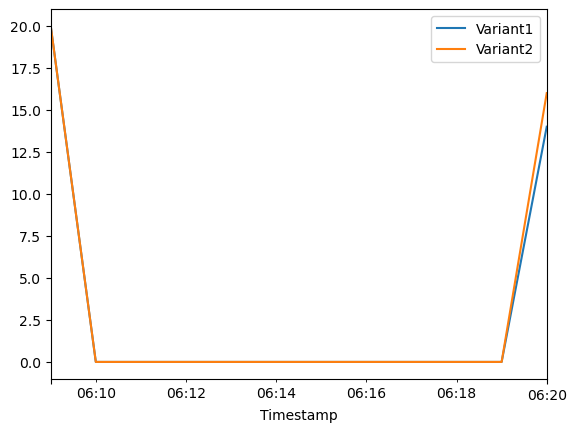

In [27]:
print("Waiting a minute for initial metric creation...")
time.sleep(60)
plot_endpoint_metrics()

**참고:** 빈 그래프와 같은 오류가 관찰되면 이전 단계를 다시 실행하세요.

### 특정 변형 호출

이제 특정 변형을 호출해 보겠습니다. 이를 위해 단순히 새 매개변수를 사용하여 호출하려는 특정 ProductionVariant를 정의합니다. 이것을 사용하여 모든 요청에 대해 Variant1을 호출해 보겠습니다.

### Variant 1

In [28]:
predictions1 = ''

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open('data/data-test.csv', 'r') as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip('\n')
        response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType="text/csv",
                                   Body=payload,
                                   TargetVariant='Variant1')
        predictions1 = ','.join([predictions1, response['Body'].read().decode('utf-8')])
        time.sleep(0.5)

predictions1 = predictions1.replace('\n','')
predictions1 = predictions1.split(",")
predictions1.pop(0)
print("="*20)
print(predictions1)
print("Done!") 

Sending test traffic to the endpoint Endpoint-dedea004-0940-4af8-b8d2-406b1e7bf105. 
Please wait...
..............................====================
['0', '0', '0', '0', '0', '2', '1', '1', '2', '1', '2', '1', '0', '2', '0', '2', '2', '0', '0', '2', '2', '2', '0', '1', '0', '0', '2', '1', '2', '1']
Done!


,Variant1,Variant2
Timestamp,,
2023-10-11 06:09:00+00:00,20.0,20.0
2023-10-11 06:10:00+00:00,0.0,0.0
2023-10-11 06:11:00+00:00,0.0,0.0
2023-10-11 06:12:00+00:00,0.0,0.0
2023-10-11 06:13:00+00:00,0.0,0.0
2023-10-11 06:14:00+00:00,0.0,0.0
2023-10-11 06:15:00+00:00,0.0,0.0
2023-10-11 06:16:00+00:00,0.0,0.0
2023-10-11 06:17:00+00:00,0.0,0.0


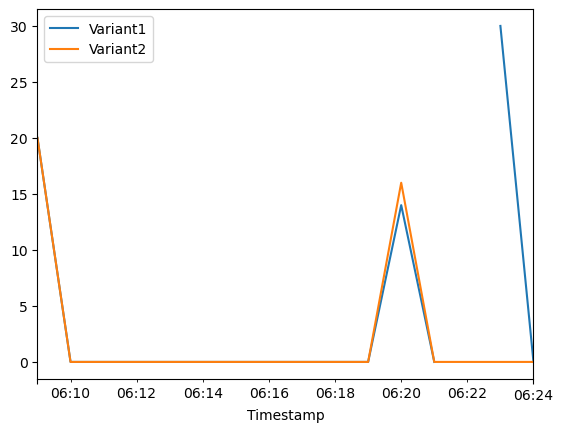

In [29]:
time.sleep(60) #let metrics catch up
plot_endpoint_metrics()

**참고:** 빈 그래프와 같은 오류가 관찰되면 이전 단계를 다시 실행하세요.

### Variant 1의 성능 평가

In [30]:
# Calculate accuracy

labels1 = test_data_with_label[0].to_numpy()
preds1 = np.array(predictions1)
preds1 = preds1.astype(np.int)

accuracy1 = np.count_nonzero(preds1 == labels1) / len(labels1)
print(f"Accuracy_variant1: {accuracy1}")

Accuracy_variant1: 0.9333333333333333


/tmp/ipykernel_14215/3759722907.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  preds1 = preds1.astype(np.int)


### Variant 2

In [31]:
predictions2 = ''

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open('data/data-test.csv', 'r') as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip('\n')
        response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType="text/csv",
                                   Body=payload,
                                   TargetVariant='Variant2')
        predictions2 = ','.join([predictions2, response['Body'].read().decode('utf-8')])
        time.sleep(0.5)

predictions2 = predictions2.replace('\n','')
predictions2 = predictions2.split(",")
predictions2.pop(0)
print("="*20)
print(predictions2)
print("Done!") 

Sending test traffic to the endpoint Endpoint-dedea004-0940-4af8-b8d2-406b1e7bf105. 
Please wait...
..............................====================
['0', '0', '0', '0', '0', '2', '1', '1', '2', '1', '2', '1', '0', '2', '0', '2', '2', '0', '0', '2', '2', '2', '0', '1', '0', '0', '2', '1', '2', '1']
Done!


,Variant1,Variant2
Timestamp,,
2023-10-11 06:09:00+00:00,20.0,20.0
2023-10-11 06:10:00+00:00,0.0,0.0
2023-10-11 06:11:00+00:00,0.0,0.0
2023-10-11 06:12:00+00:00,0.0,0.0
2023-10-11 06:13:00+00:00,0.0,0.0
2023-10-11 06:14:00+00:00,0.0,0.0
2023-10-11 06:15:00+00:00,0.0,0.0
2023-10-11 06:16:00+00:00,0.0,0.0
2023-10-11 06:17:00+00:00,0.0,0.0


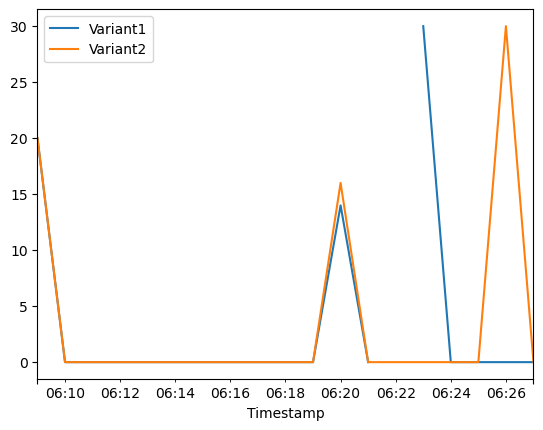

In [32]:
time.sleep(60) #let metrics catch up
plot_endpoint_metrics()

**참고:** 빈 그래프와 같은 오류가 관찰되면 이전 단계를 다시 실행하세요.

### Variant 2의 성능 평가

In [33]:
# Calculate accuracy

labels2 = test_data_with_label[0].to_numpy()
preds2 = np.array(predictions2)
preds2 = preds2.astype(np.int)

accuracy2 = np.count_nonzero(preds2 == labels2) / len(labels2)
print(f"Accuracy_variant2: {accuracy2}")

Accuracy_variant2: 0.9333333333333333


/tmp/ipykernel_14215/3479068715.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  preds2 = preds2.astype(np.int)


## 3단계: 프로덕션 환경에서 선택한 변형으로 전환

Variant1과 비교하여 Variant2가 더 나은 것으로 결정되었으므로 더 많은 트래픽을 이 위치로 이동합니다.

TargetVariant를 계속 사용하여 선택한 변형을 계속 호출할 수 있습니다. 더 간단한 방법은 UpdateEndpointWeightsAndCapacities를 사용하여 각 변형에 할당된 가중치를 업데이트하는 것입니다. 이렇게 하면 엔드포인트를 업데이트하지 않고도 프로덕션 변형에 대한 트래픽 분포가 변경됩니다.

변형 가중치는 다음과 같습니다.

In [34]:
{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

{'Variant1': 1.0, 'Variant2': 1.0}

먼저 엔드포인트(이전에 수행한 작업의 복사본)를 쉽게 호출하는 메서드를 작성합니다.

In [35]:
def invoke_endpoint_for_two_minutes():
    with open('data/data-test.csv', 'r') as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip('\n')
            response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                                  ContentType='text/csv', 
                                                  Body=payload)
            response['Body'].read()
            time.sleep(1)

호출에서 균등 분할을 표시하기 위해 잠시 엔드포인트를 호출합니다.

**참고** 이 단계를 완료하는 데 3-5분이 소요됩니다.

..............................

,Variant1,Variant2
Timestamp,,
2023-10-11 06:29:00+00:00,21.0,8.0
2023-10-11 06:30:00+00:00,1.0,0.0


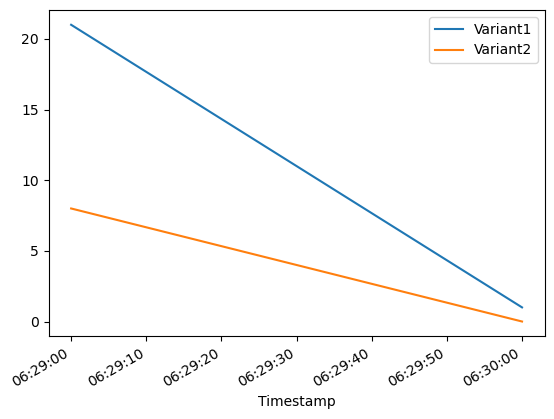

In [36]:
invocation_start_time = datetime.now()
invoke_endpoint_for_two_minutes()
time.sleep(120) # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

**참고:** 빈 그래프와 같은 오류가 관찰되면 이전 단계를 다시 실행하세요.

이제 UpdateEndpointWeightsAndCapacities를 사용하여 각 변형에 새 가중치를 할당하여 트래픽의 75%를 Variant2로 이동하겠습니다. Amazon SageMaker는 이제 추론 요청의 75%를 Variant2로 보내고 나머지 25%를 Variant1로 보냅니다.

In [37]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {
            "DesiredWeight": 25,
            "VariantName": 'Variant1'
        },
        {
            "DesiredWeight": 75,
            "VariantName": 'Variant2'
        }
    ]
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:512585161416:endpoint/endpoint-dedea004-0940-4af8-b8d2-406b1e7bf105',
 'ResponseMetadata': {'RequestId': 'b48fd012-2f50-478e-8b95-7f926e0a9073',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b48fd012-2f50-478e-8b95-7f926e0a9073',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Wed, 11 Oct 2023 06:33:34 GMT'},
  'RetryAttempts': 0}}

In [38]:
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
............................................Done


{'Variant1': 25.0, 'Variant2': 75.0}

..............................

,Variant1,Variant2
Timestamp,,
2023-10-11 06:29:00+00:00,21.0,8.0
2023-10-11 06:30:00+00:00,1.0,0.0
2023-10-11 06:31:00+00:00,0.0,0.0
2023-10-11 06:32:00+00:00,0.0,0.0
2023-10-11 06:33:00+00:00,0.0,0.0
2023-10-11 06:34:00+00:00,0.0,0.0
2023-10-11 06:35:00+00:00,NaN,1.0
2023-10-11 06:36:00+00:00,5.0,24.0
2023-10-11 06:37:00+00:00,0.0,0.0


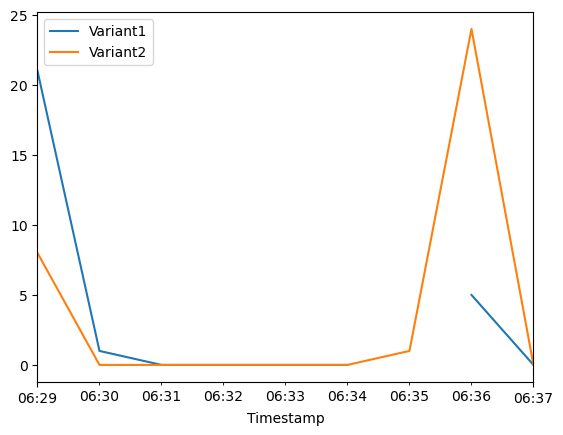

In [39]:
invoke_endpoint_for_two_minutes()
time.sleep(120) # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

**참고:** 빈 그래프와 같은 오류가 관찰되면 이전 단계를 다시 실행하세요.

측정항목을 계속 모니터링할 수 있으며 변형의 성능에 만족하면 트래픽의 100%를 변형을 통해 라우팅할 수 있습니다. UpdateEndpointWeightsAndCapacities를 사용하여 변형에 대한 트래픽 할당을 업데이트했습니다. Variant1의 가중치는 0으로 설정되고 Variant2의 가중치는 1로 설정됩니다. 따라서 SageMaker는 모든 추론 요청의 100%를 Variant2로 보냅니다.

### 도전

이제 트래픽을 조정하는 방법을 알았습니다. 다음 코드를 완성하여 100% 트래픽을 Variant2로 보내 봅시다.

In [ ]:
## Add your solution here

In [ ]:
invoke_endpoint_for_two_minutes()
time.sleep(120) # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

**참고:** 빈 그래프와 같은 오류가 관찰되면 이전 단계를 다시 실행하세요.

각 변형에 대한 총 호출에 대한 Amazon CloudWatch 지표는 모든 추론 요청이 Variant2에서 처리되고 있고 Variant1에서 처리된 추론 요청이 없음을 나타냅니다.

이제 안전하게 엔드포인트를 업데이트하고 여기에서 Variant1을 삭제할 수 있습니다. 끝점에 새 변형을 추가하고 2 - 4단계를 수행하여 프로덕션에서 새 모델을 계속 테스트할 수도 있습니다.

정답을 보려면 **[Lab 4 A/B 테스트 솔루션](../solutions/Lab4-AB_Testing-Solution.ipynb)**을 참조하세요.

## 엔드포인트 삭제

이 엔드포인트를 더 이상 사용할 계획이 없으면 추가 요금이 발생하지 않도록 삭제해야 합니다.

In [ ]:
sm_session.delete_endpoint(endpoint_name)